# Bootstrapping with 1-D harmonic potential

In this code, we demonstrate 1-dimensional harmonic potential with $\hbar = 1$ and $m = 1$. We begin with

\begin{align*}
    H &= \frac{P^2}{2m}+V(x)\\
    V(x) &= kx^2\\
    [X,P] &= i
\end{align*}

Since for any operator $O$, we have $\langle E|[H, O]|E\rangle=0$, consider $O_1=X^{s}P$ and $O_2=X^{s-1}$
\begin{align*}
    [H, O_1] = [H, X^{s}P] &= 0 = 
    -\frac{1}{2}s(s-1)\langle X^{s-2}P\rangle 
    -is\langle X^{s-1}P^2\rangle+
    i\langle X^{s}V^\prime(x)\rangle\\
    
    [H, O_2] = [H, X^{s-1}] &= 0 =
    -\frac{1}{2}(s-1)(s-2)\langle X^{s-3}\rangle
    -i(s-1)\langle X^{s-2}P\rangle
\end{align*}

Conbine these two equations, we can get
\begin{equation*}
    0 = \frac{1}{4}s(s-1)(s-2)\langle X^{s-3}\rangle
    +s\langle X^{s-1}P^2\rangle
    -\langle X^sV^\prime (x)\rangle
\end{equation*}

Now consider $\langle E|X^{s-1}H|E\rangle$
\begin{align*}
    \langle E|X^{s-1}H|E\rangle & = E\langle X^{s-1}\rangle \\
    \langle E|X^{s-1}H|E\rangle & = \frac{1}{2}\langle X^{s-1}P^2\rangle + \langle X^{s-1}V(x)\rangle \\
\end{align*}

So we have $\langle X^{s-1}P^2\rangle = 2E\langle X^{s-1}\rangle - 2\langle X^{s-1}V(x)\rangle$, substitute into the equation above and finally we get
\begin{equation*}
    0 = 2sE\langle X^{s-1}\rangle + \frac{1}{4}s(s-1)(s-2)\langle X^{s-3}\rangle 
    - \langle X^s V^\prime (x)\rangle - 2s\langle X^{s-1}V(x)\rangle
\end{equation*}

In [1]:
import os, time
import numpy as np
import sympy as sp
from bootstrap_sympy import sympy_solve_intervals, plot_energy_interval

import matplotlib.pyplot as plt
import seaborn as sns

## Recursion relation for 1-d harmonic potential

Plug in $V(x)=kx^2$ into the recursion relation, we get

\begin{equation*}
    \langle X^{s}\rangle \ =\  \frac{(s-1)E}{ks}\langle X^{s-2}\rangle + \frac{(s-1)(s-2)(s-3)}{8ks}\langle X^{s-4}\rangle
\end{equation*}

With $\langle X^0\rangle=1$ by normalization, and $\langle X^1\rangle=0$ by symmetry

In [2]:
class HarmonicPotentialMatrix:
    def __init__(self, N):
        self.k = sp.symbols('k') # constant of harmonic potential
        self.E = sp.symbols('E') # eigen-energy to be solved
        
        self.Xs_list = [] # list of X^s, the expectation value of position operator X to the s power
        for i in range(2*(N-1)+1):
            if i >= 4:
                self.Xs_list.append(self.Xs_recursion(s=i, Xs_2=self.Xs_list[i-2], Xs_4=self.Xs_list[i-4]))
            else:
                self.Xs_list.append(self.Xs_recursion(s=i))

    def Xs_recursion(self, s, Xs_2=None, Xs_4=None):
        # find the <X^s> with recursion relation
        if s == 0:
            return 1
        elif s == 2:
            return self.E * sp.Rational(1,2) / self.k
        elif s%2 != 0:
            return 0
        else:
            if Xs_2 == None or Xs_4 == None:
                Xs_2 = self.Xs_recursion(s-2)
                Xs_4 = self.Xs_recursion(s-4)
            result  = self.E * sp.Rational((s-1),s) / self.k * Xs_2
            result += sp.Rational((s-1)*(s-2)*(s-3),8*s) / self.k * Xs_4
            return result

    def submatrix(self, L):
        # L*L matrix's [i,j] element = <X^(i+j)>
        return sp.Matrix([[self.Xs_list[i+j] for j in range(L)] for i in range(L)])

In [3]:
hp_config = {
    'x_inf' : 0,
    'x_sup' : 10,
    'round' : 18,
    'plot_step' : 3,
    'threshold' : 1e-3,
    'initial_interval' : sp.Interval(0, sp.oo),
}

hp_matrix = HarmonicPotentialMatrix(N=hp_config['round'])
hp_hyperparameters = {
    hp_matrix.k : 0.5,
}

energy_intervals, confirmed_intervals = sympy_solve_intervals(hp_matrix, hp_config, hp_hyperparameters, det_indep=False, confirm=True)

Now calculating determinant size 1x1
Time cost = 0.00
Round interval = Interval(0, oo)

Now calculating determinant size 2x2
Time cost = 0.01
Round interval = Interval(0, oo)

Now calculating determinant size 3x3
Time cost = 0.05
Round interval = Interval(0, oo)

Now calculating determinant size 4x4
Time cost = 0.08
Round interval = Interval(0.264017327130108, oo)

Now calculating determinant size 5x5
Time cost = 0.12
Round interval = Interval(0.264017327130108, oo)

Now calculating determinant size 6x6
Time cost = 0.29
Round interval = Interval(0.417458228325692, oo)

Now calculating determinant size 7x7
Time cost = 0.55
Round interval = Union(Interval(0.417458228325692, 0.566507626022330), Interval(1.13185451266325, oo))

Now calculating determinant size 8x8
Time cost = 1.10
Round interval = Union(Interval(0.480732040704975, 0.566507626022330), Interval(1.13185451266325, oo))

Now calculating determinant size 9x9
Time cost = 1.57
Round interval = Union(Interval(0.480732040704975, 0.5

In [4]:
print(f"Confirmed intervals = {sp.N(confirmed_intervals)}")

Confirmed intervals = Union(Interval(0.499491801446948, 0.500193530731706), Interval(1.49955026125903, 1.50021788252938))


In [15]:
k = hp_hyperparameters[hp_matrix.k]
energy_eigenvalues = [0.5 * (2*k)**0.5]
while energy_eigenvalues[-1] < hp_config['x_sup']:
    energy_eigenvalues.append(energy_eigenvalues[-1] + (2*k)**0.5)

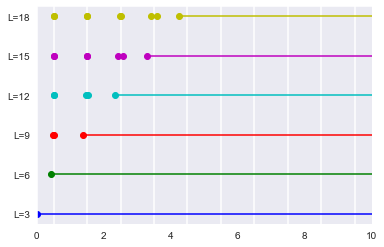

In [16]:
if not os.path.exists(os.path.abspath('harmonic')):
    os.mkdir(os.path.abspath('harmonic'))

np.save(os.path.join(os.path.abspath('harmonic'), 'energy_intervals.npy'), energy_intervals, allow_pickle=True)
np.save(os.path.join(os.path.abspath('harmonic'), 'confirmed_intervals.npy'), confirmed_intervals, allow_pickle=True)

sns.set_style('dark')
fig, ax = plot_energy_interval(energy_intervals, energy_eigenvalues, hp_config)
plt.savefig(os.path.join(os.path.abspath('harmonic'), 'result.png'))